# San Francisco Crime Analytics: Predicting Crime Categories
[*Kaggle San Francisco Crime Classification competition*](https://www.kaggle.com/c/sf-crime)  
Meghann Agarwal

## Introduction

This is my attempt at the Kaggle practice competition "San Francisco Crime Classification."  In my previous post I explored the data visually and got a feel for things.  In this post I will focus on applying machine learning algorithms and submitting predictions in the competition.  

The task of the competition is to predict the category of a crime incident (e.g., Assault, Larceny/Theft, Trespass) in San Francisco based on the time and location of the reported crime.  The San Francisco Police Department keeps track of crime incident reports in the city and uploads them to [SF OpenData](https://data.sfgov.org/) for public consumption.  Kaggle has taken and slightly restructured the data set for dates between 1/1/2003 and 5/13/2015.  The data have already been split into test (odd weeks) and training (even weeks) sets.  Participants should train the data on some machine learning model and submit a set of predicted probabilities (one for every crime category) for each incident in the test data.  The set of probabilities is then compared to the true incident category according to the [multi-class logarithmic loss formula](https://www.kaggle.com/wiki/MultiClassLogLoss) to evaluate each submission.


### Import Python Libraries

In [1]:
# Plotting libraries/settings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
%matplotlib inline

# Data manipulation libraries/settings
import numpy as np
import pandas as pd
pd.options.display.max_rows=6
pd.options.display.max_columns=10

# Machine learning library/functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Print version info for the sake of reproducibility
import sys
import matplotlib as mpl
import sklearn as skl
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("sklearn" + skl.__version__)

python 3.5.1 |Anaconda custom (x86_64)| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]

pandas 0.18.0
numpy 1.10.4
matplotlib 1.5.1
seaborn 0.7.0
sklearn0.17.1


 ## Load Kaggle Titanic Data

In [3]:
df_train = pd.read_csv("./data/kaggle/train.csv", 
                       parse_dates=['Dates'],
                       infer_datetime_format=True)
df_test = pd.read_csv("./data/kaggle/test.csv",
                      parse_dates=['Dates'],
                      infer_datetime_format=True)

In [4]:
print("-----------------")
print("Training Data Set")
print("-----------------")
df_train.info()
df_train

-----------------
Training Data Set
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
...,...,...,...,...,...,...,...,...,...
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


In [5]:
print("----------------")
print("Testing Data Set")
print("----------------")
df_test.info()
df_test

----------------
Testing Data Set
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null datetime64[ns]
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 47.2+ MB


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
...,...,...,...,...,...,...,...
884259,884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075
884260,884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479
884261,884261,2003-01-01 00:01:00,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950


In [6]:
print("Number of unique crime categories:", len(df_train['Category'].unique()))
print("")
print(df_train['Category'].unique())

Number of unique crime categories: 39

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


## Clean Data
Each data set contains around 880 thousand crime incidents (rows). Now we want to clean the data and prepare it for predictive modeling.

Notice that the training set has three columns not present in the test set: "Category," "Descript," and "Resolution." The test set has an additional "Id" column that corresponds to the row indices. 
- Our end goal is to predict the crime category, which is why "Category" is not present in the testing data.
- We can remove "Descript" and "Resolution" from the training set since those features are not present in the test set. 
- We will remove the "Id" column from the test set and use the `pandas` dataframe row indices instead.

Also, there are no missing values in the training or testing data sets, but I know from my prior exploratory data analysis that there are some erroneous "X" (= longitude) and "Y" (= latitude) values that need to be imputed. I think it makes sense to replace the erroneous X/Y values with perhaps the average X/Y values for each police district. However, let's just drop those columns for now and focus on the other location-related features: "PdDistrict" and "Address." 

In [7]:
df_train.drop(["Descript", "Resolution", "X", "Y"], axis=1, inplace=True)
df_test.drop(["Id", "X", "Y"], axis=1, inplace=True)

In [8]:
df_train

,Dates,Category,DayOfWeek,PdDistrict,Address
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST
2,2015-05-13 23:33:00,OTHER OFFENSES,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST
...,...,...,...,...,...
878046,2003-01-06 00:01:00,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST
878047,2003-01-06 00:01:00,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,Monday,BAYVIEW,1800 Block of NEWCOMB AV


In [9]:
df_test

,Dates,DayOfWeek,PdDistrict,Address
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST
...,...,...,...,...
884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST
884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV
884261,2003-01-01 00:01:00,Wednesday,TARAVAL,1500 Block of SLOAT BL


In [ ]:
# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_train  = pd.get_dummies(df_train['PdDistrict'])
#person_dummies_train.drop(['Male'], axis=1, inplace=True)
person_dummies_train

In [ ]:
df_train = df_train.join(person_dummies_titanic)
df_test = df_test.join(person_dummies_test)

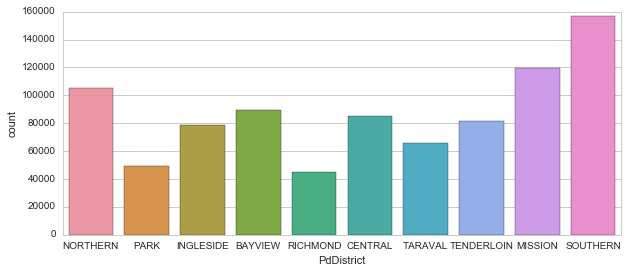

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='PdDistrict', data=df_train, ax=ax)

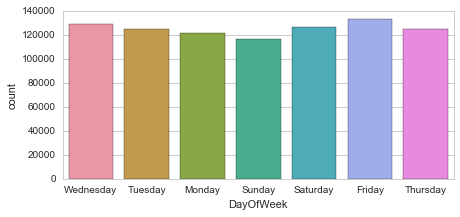

In [21]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.countplot(x='DayOfWeek', data=df_train, ax=ax)

In [17]:
print("Number of unique addresses:", len(df_train['Address'].unique()))

Number of unique addresses: 23228


## First Attempt at Prediction
This is a supervised classification problem since we are given labeled outputs ("Category") in the training set, and the attribute we are trying to "learn" is categorical.

We can see that our features are related to either time ("Dates" and "DayOfWeek") or location ("PdDistrict" and "Address"). As a first pass I'll try using a decision tree to model the training data.

In [ ]:
X_train = df_train.drop(["Address", "Category"],axis=1)
Y_train = df_train["Category"]
X_test  = df_test.copy()

In [ ]:
# Logistic Regression
tree = LogisticRegression()
logreg.fit(X_train, Y_train)

In [ ]:
Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

## Second Attempt at Prediction

## Conclusion